# Importing Libraries.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import random
from pathlib import Path

E:\Anaconda\envs\pytorch39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting up device agnostic code.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Making train and test directory

In [3]:
# Making train and test dir.

train_dir = "E://Image Dataset/DogCat/train"
test_dir = "E://Image Dataset/DogCat/validation"
print(f"[INFO] : The train_dir is {train_dir} \n The test_dir is {test_dir}")

[INFO] : The train_dir is E://Image Dataset/DogCat/train 
 The test_dir is E://Image Dataset/DogCat/validation


# Making a transfer learning model of vgg16.

In [4]:
def create_vgg16(num_classes:int):
    weights = torchvision.models.VGG16_Weights.DEFAULT
    model = torchvision.models.vgg16(weights=weights)
    transforms = weights.transforms()

    # Freeze the layers.
    for param in model.parameters():
        param.requires_grad = False
    
    # number of features.
    num_ftrs = model.classifier[0].in_features

    # making the model.
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3 , inplace=True),
        nn.Linear(in_features=num_ftrs , out_features=num_classes)
    )

    return model , transforms

# Checking the summary of the model.

In [5]:
model , data_transform = create_vgg16(2)
summary(model=model,
        input_size=(32,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

E:\Anaconda\envs\pytorch39\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
E:\Anaconda\envs\pytorch39\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

# Create DataLoaders.

In [6]:
# Creating train and test data.
train_data = ImageFolder(root = train_dir , transform=data_transform)
test_data = ImageFolder(root = test_dir , transform=data_transform)


# Setting up hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Creating train and test dataloader.
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             )

# Getting the class names
class_names = train_data.classes
print(class_names)

['cats', 'dogs']


# Visualize the train data.

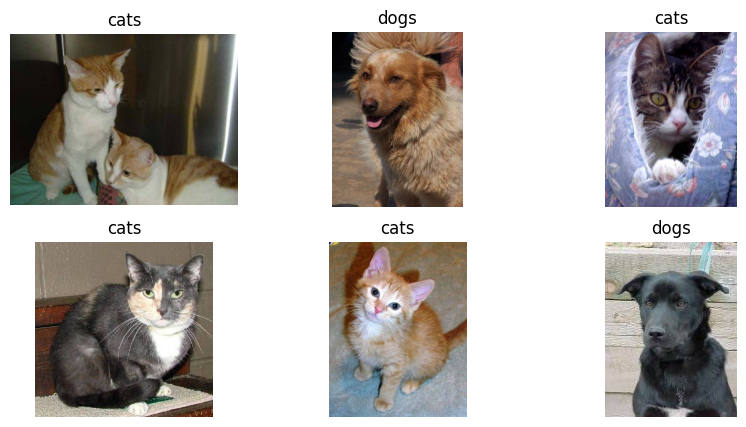

In [7]:
random_path = list(Path(test_dir).glob("*/*.jpg"))
random_path = random.sample(random_path , k =6)

plt.figure(figsize=(10,5))
for i,image in enumerate(random_path):
    plt.subplot(2,3,i+1)
    img = Image.open(image)
    label = image.parent.stem
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# Making functions of train_step , test_step , train.

In [8]:
def train_step(model,
               dataloader,
               loss_fn,
               optimizer,
               device):
    # Put model in train mode
    model.train()

  # Setup train loss and train accuracy values
    train_loss , train_acc = 0,0

    # Loop through data loader data batches
    for batch,(x,y) in enumerate(dataloader):
        # Send data to target device
        x,y = x.to(device) , y.to(device)

        # 1. Forward pass
        y_pred = model(x)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss , train_acc

def test_step(model,
              dataloader,
              loss_fn,
              device):
    
    # Put model in eval mode
    model.eval()
    # Setup test loss and test accuracy values
    test_loss , test_acc = 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch , (x,y) in enumerate(dataloader):
            # Send data to target device
            x,y = x.to(device),y.to(device)

            # 1. Forward pass
            test_pred = model(x)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred,y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_class = torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
            test_acc += (test_pred_class == y).sum().item() / len(test_pred_class)
    
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss , test_acc

def train(model,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn,
          optimizer,
          epochs,
          device):
    
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

# Training

In [9]:
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001)

vgg16_results = train(model,
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS,
                      device)

 20%|████████████████▊                                                                   | 1/5 [01:01<04:07, 61.87s/it]

Epoch: 1 | train_loss: 0.2205 | train_acc: 0.9337 | test_loss: 0.0469 | test_acc: 0.9852


 40%|█████████████████████████████████▌                                                  | 2/5 [01:56<02:53, 57.77s/it]

Epoch: 2 | train_loss: 0.0125 | train_acc: 0.9962 | test_loss: 0.0467 | test_acc: 0.9832


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:54<01:55, 57.59s/it]

Epoch: 3 | train_loss: 0.0011 | train_acc: 1.0000 | test_loss: 0.0508 | test_acc: 0.9832


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:02<01:01, 61.75s/it]

Epoch: 4 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 0.0395 | test_acc: 0.9885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:58<00:00, 59.67s/it]

Epoch: 5 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.0387 | test_acc: 0.9885


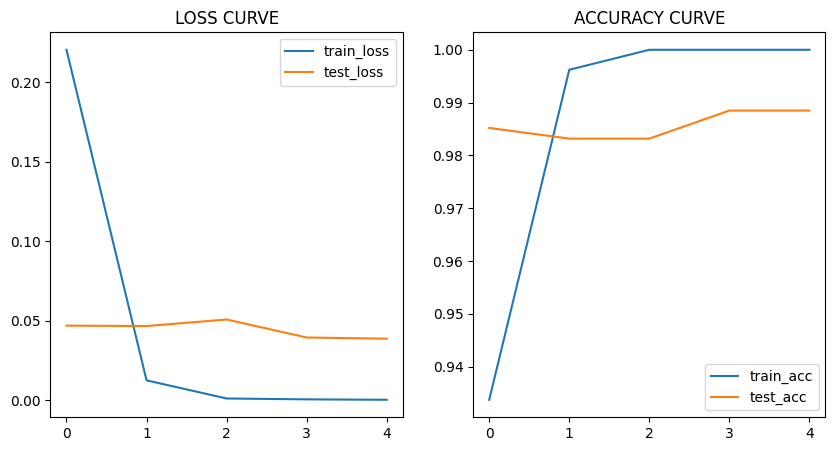

In [10]:
epochs = range(len(vgg16_results["train_loss"]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs , vgg16_results['train_loss'],label = "train_loss")
plt.plot(epochs,vgg16_results['test_loss'] , label = "test_loss")
plt.title("LOSS CURVE")
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, vgg16_results['train_acc'],label = "train_acc")
plt.plot(epochs, vgg16_results['test_acc'] , label = "test_acc")
plt.title("ACCURACY CURVE")
plt.legend()

In [11]:
model_path = Path("models")
if model_path.is_dir():
    print("already Exists")
else:
    model_path.mkdir()
model_name = "Cat_Dog_vgg16.pth"
model_save_path = model_path / model_name

torch.save(obj = model.state_dict(),
          f = model_save_path)

already Exists


# Loading the Model

In [12]:
vgg16 , vgg16_transforms = create_vgg16(2)

vgg16.load_state_dict(
    torch.load(f="models/Cat_Dog_vgg16.pth",
              map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [13]:
from timeit import default_timer as timer 
def predict(img):
    start_time = timer()
    

    img = vgg16_transforms(img).unsqueeze(0)
    
    vgg16.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(vgg16(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    

    pred_time = round(timer() - start_time, 5)
    
    return pred_labels_and_probs, pred_time

In [17]:
import gradio as gr

# Create title, description and article strings
title = "Cat Dog Classification 🐱🐶"
description = "An VGG16 feature extractor computer vision model to classify images of CAT and DOG."
article = "Created at Sarthak Samantaray"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://4ffc32de466be3c0ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


ReadTimeout: HTTPSConnectionPool(host='4ffc32de466be3c0ef.gradio.live', port=443): Read timed out. (read timeout=3)

# Plotting Predictions using matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


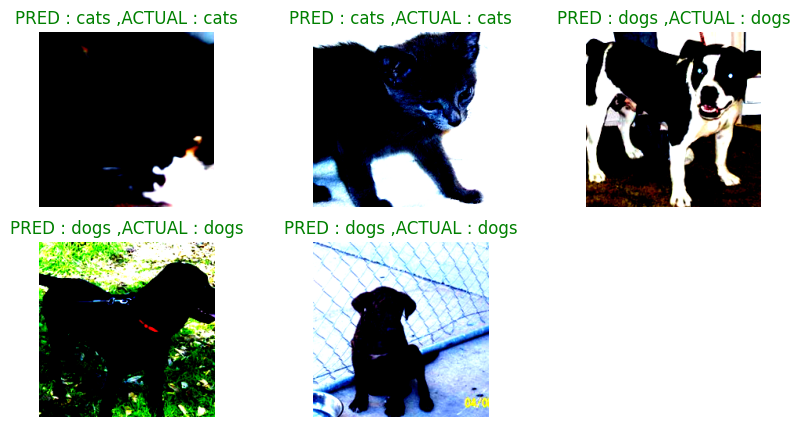

In [15]:
import numpy as np

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=5)

plt.figure(figsize = (10,5))
for i,images in enumerate(random_image_path):
    class_names = train_data.classes
    actual_classes = images.parent.stem
    plt.subplot(2,3,i+1)
    img = Image.open(images)
    
    model = vgg16
    model.eval()
    with torch.inference_mode():
        img = data_transform(img)
        img = img.unsqueeze(dim=0)
        
        y_pred = model(img)
        y_pred_probs = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        y_pred_classes = class_names[y_pred_probs]
        
        plt.imshow(img.squeeze().permute(1,2,0).cpu())
        plt.title(f"PRED : {y_pred_classes} ,ACTUAL : {actual_classes}",c = "green" if y_pred_classes == actual_classes else "red")
        plt.axis('off')

from torchvision import datasets, transforms
transform = torchvision.transforms.Compose([
    transforms.ToTensor()
])